In [1]:
import sys
sys.path.append("..")


In [2]:
# %pip install dash

In [3]:
# %pip install UMAP
# %pip install umap
# %pip install --upgrade umap-learn
# %pip install -U kaleido

In [4]:
# %pip install loguru
# %pip install numpy
# %pip install openai
# %pip install plotly

In [5]:
# %pip install nbformat==4.2.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, cosine_distances
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import matplotlib.colors as mcolors
import warnings
import io
from PIL import Image
import nbformat
import IPython
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from dch_etl.azure_clients.openai_client import OpenAiClient

#from azure.core.credentials import AzureKeyCredential
#from azure.search.documents import SearchClient

## Importar y crear df

In [4]:
import csv

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\cluster_centroids.csv'
with open(file_path, "r") as file:
    reader = csv.DictReader(file)
    keys = reader.fieldnames
    results = list(reader)


In [6]:
centroides_df = pd.read_csv(file_path)

# Check if the specified columns exist before selecting them
columns = ['cluster_label', 'centroid', 'etiqueta']
missing_columns = [col for col in columns if col not in centroides_df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
else:
    centroides_df = centroides_df[columns]


In [7]:
import json

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\documentos_pre.json'
with open(file_path, "r") as file:
    results2 = json.load(file)

In [8]:
embeddings_df = pd.DataFrame(results2)[["id", "content", "content_type","category", "content_vector", 'document_id', 'chunk_id']]

Normalizar los vectores en content_vector

In [9]:
# Función para normalizar un vector
def normalizar_vector(vector):
    norma = np.linalg.norm(vector)
    return vector / norma if norma != 0 else vector

# Aplicar la normalización a cada vector en la columna content_vector
embeddings_df['content_vector_norm'] = embeddings_df['content_vector'].apply(normalizar_vector)

print("Vectores normalizados con éxito.")

Vectores normalizados con éxito.


Asignar etiqueta a cada embedding normalizado

In [10]:
# Convertir centroides a un array de numpy, asegurando que son numéricos
centroides = np.array([np.fromstring(c[1:-1], sep=',') for c in centroides_df['centroid'].values])

# Verifica las dimensiones
print("Dimensiones de los embeddings:", embeddings_df['content_vector_norm'].iloc[0].shape)
print("Dimensiones de los centroides:", centroides.shape)

# Función para calcular la distancia Euclidiana
def calcular_distancia(embedding, centroides):
    return np.linalg.norm(centroides - embedding, axis=1)

# Listas para almacenar las etiquetas y los centroides más cercanos
etiquetas_cercanas = []
centroides_cercanos = []

# Iterar sobre cada embedding en embeddings_df
for index, row in embeddings_df.iterrows():
    embedding = row['content_vector_norm']
    distancias = calcular_distancia(embedding, centroides)
    indice_minimo = np.argmin(distancias)
    
    # Agregar la etiqueta y el centroide correspondiente al DataFrame
    etiquetas_cercanas.append(centroides_df['etiqueta'].iloc[indice_minimo])
    centroides_cercanos.append(centroides[indice_minimo])

# Crear nuevas columnas en embeddings_df
embeddings_df['etiqueta_asignada'] = etiquetas_cercanas
embeddings_df['centroide'] = centroides_cercanos



Dimensiones de los embeddings: (3072,)
Dimensiones de los centroides: (37, 3072)


# I) Análisis en función del content type

In [52]:
# Count the quantity of chunk_id per content_type
chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()

# Rename the columns for clarity
chunk_count_per_type.columns = ['content_type', 'chunk_count']

# Print the result
print(chunk_count_per_type)


  content_type  chunk_count
0         aspx         2277
1         html            3
2          jpg            6
3          pdf         3387
4          png            8
5         xlsx           74


In [53]:
def chunks_per_content():
    chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['content_type', 'chunk_count']

    # Sort by chunk_count in descending order
    chunk_count_per_type = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

    # Asegúrate de que chunk_count_per_type esté ordenado correctamente
    chunk_count_per_type_sorted = chunk_count_per_type.sort_values(by='chunk_count')

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='content_type', y='chunk_count', data=chunk_count_per_type_sorted, palette='viridis')

    # Configurar el eje Y en escala logarítmica
    ax.set(yscale="log")

    # Títulos y etiquetas
    ax.set_title('Count of Chunk IDs per Content Type')
    ax.set_xlabel('Content Type')
    ax.set_ylabel('Count of Chunk IDs (log scale)')
    fig = ax.get_figure()
    # Mostrar la figura
    # plt.show()
    return fig



El gráfico muestra la cantidad de IDs de fragmentos por tipo de contenido, utilizando una escala logarítmica en el eje y. Aquí están las principales observaciones:

1. **PDF**: Es el tipo de contenido con la mayor cantidad de IDs de fragmentos, superando los 1000.
2. **ASPX**: También tiene una cantidad significativa de IDs de fragmentos, similar a los PDFs, pero ligeramente menor.
3. **XLSX**: Tiene una cantidad considerable de IDs de fragmentos, aunque significativamente menor que los tipos PDF y ASPX.
4. **PNG y JPG**: Ambos tipos de contenido tienen una cantidad moderada de IDs de fragmentos, con los PNGs ligeramente por encima de los JPGs.
5. **HTML**: Tiene la menor cantidad de IDs de fragmentos, con un valor muy bajo en comparación con los otros tipos de contenido.

En resumen, los tipos de contenido PDF y ASPX dominan en términos de cantidad de IDs de fragmentos, mientras que HTML tiene la menor cantidad.


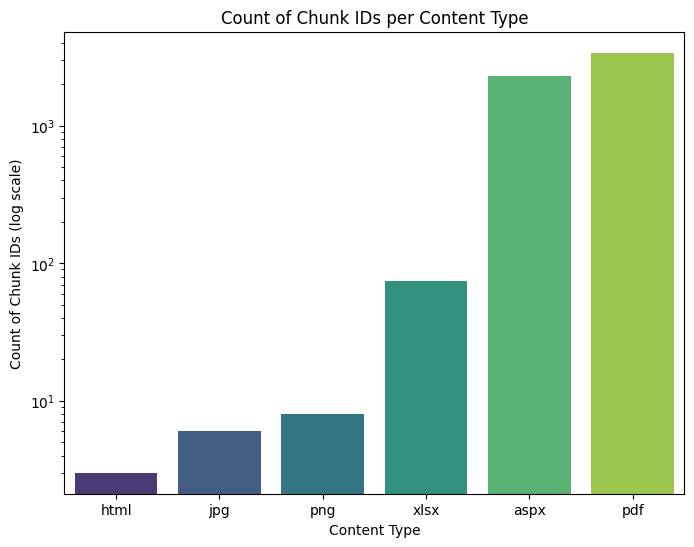

In [63]:
warnings.filterwarnings("ignore")
fig=chunks_per_content()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)

# The result is the interpretation text from the model
print(interpretation)

In [25]:
# def chunks_per_content():
#     # Count the quantity of chunk_id per content_type
#         chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()
#         chunk_count_per_type.columns = ['content_type', 'chunk_count']

#         # Sort by chunk_count in descending order
#         chunk_count_per_type = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

#         # Create a bar plot with a logarithmic y-axis
#         fig = px.bar(chunk_count_per_type,
#                     x='content_type',
#                     y='chunk_count',
#                     title='Count of Chunk IDs per Content Type',
#                     labels={'content_type': 'Content Type',
#                             'chunk_count': 'Count of Chunk IDs'},
#                     color='chunk_count',  # Color by chunk count
#                     color_continuous_scale=px.colors.sequential.Viridis)  # Optional color scale

#         # Update layout for logarithmic scale
#         fig.update_layout(
#             yaxis_type='log',  # Set y-axis to logarithmic scale
#             yaxis_title='Count of Chunk IDs (log scale)',
#             xaxis_title='Content Type',
#             height=600,
#             width=800
#         )

#         return fig


pruebas Javi

In [32]:
fig.savefig("pr.pdf")

In [ ]:
fig=chunks_per_content()

#fig2, ax = plt.subplots(4,3, figsize = (10,20))

#ax[0] = fig

El valor es {{a}}

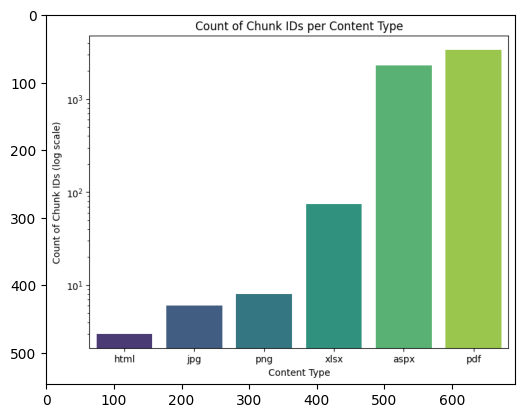

In [27]:
fig_array = fig_to_image(fig)
plt.imshow(fig_array)

In [60]:
def doc_count():
    doc_count_per_type = embeddings_df.groupby('content_type')['document_id'].nunique().reset_index()
    doc_count_per_type.columns = ['content_type', 'doc_count']

    # Sort by doc_count in descending order
    doc_count_per_type = doc_count_per_type.sort_values(by='doc_count', ascending=False)

    # Create the bar plot with seaborn
    fig, ax = plt.subplots(figsize=(10, 6))  # Create the figure and axes

    # Create the bar plot
    sns.barplot(x='content_type', y='doc_count', data=doc_count_per_type, palette='viridis', ax=ax)

    # Set the y-axis to logarithmic scale
    ax.set(yscale='log')

    # Set titles and labels
    ax.set_title('Count of Document IDs per Content Type')
    ax.set_xlabel('Content Type')
    ax.set_ylabel('Count of Document IDs (log scale)')

    # Rotate x-axis labels if needed (especially useful for long content_type labels)
    plt.xticks(rotation=45, ha='right')

    # Return the figure and axes so it can be used externally if needed
    plt.tight_layout()  # Adjust layout to make sure everything fits
    return fig


El gráfico muestra la cantidad de IDs de documentos por tipo de contenido en una escala logarítmica. Las principales tendencias y conclusiones son las siguientes:

1. **PDF y ASPX**: Los tipos de contenido más comunes son los documentos PDF y ASPX, con una cantidad significativamente mayor de IDs de documentos en comparación con otros tipos. Los PDFs tienen la mayor cantidad, seguidos de cerca por los ASPX.

2. **XLSX y PNG**: Los documentos de tipo XLSX y PNG tienen una cantidad moderada de IDs de documentos, considerablemente menor que los PDFs y ASPX, pero aún más alta que los JPG y HTML.

3. **JPG y HTML**: Los tipos de contenido JPG y HTML tienen la menor cantidad de IDs de documentos, con HTML siendo el tipo de contenido menos común.

En resumen, los documentos PDF y ASPX son los más prevalentes, mientras que los documentos HTML son los menos comunes.


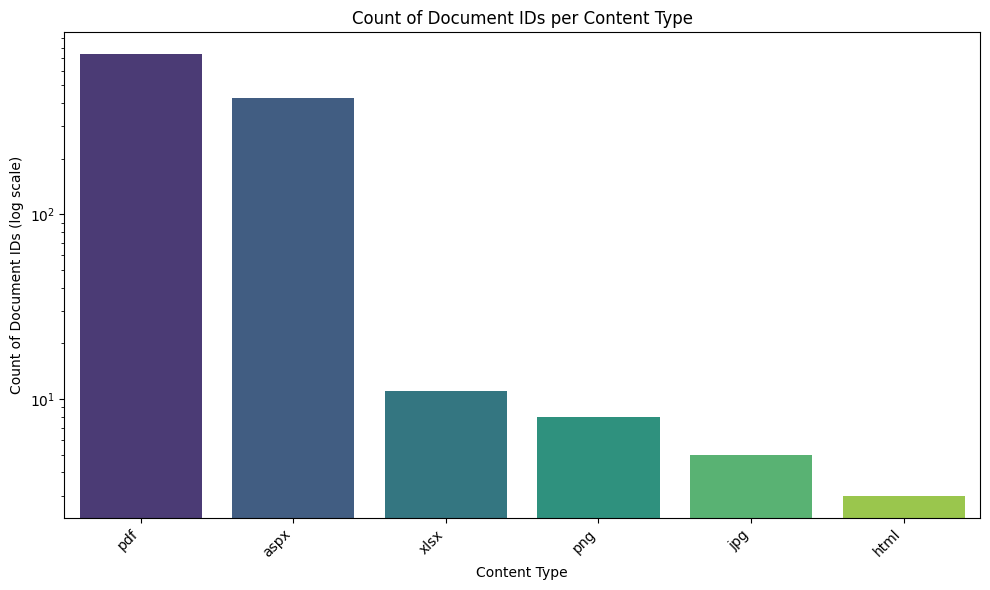

In [73]:
warnings.filterwarnings("ignore")
fig=doc_count()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [74]:
def chunk_doc_relation():
    chunk_count_per_type = embeddings_df.groupby('content_type')['chunk_id'].count().reset_index()
    chunk_count_per_type.columns = ['content_type', 'chunk_count']

    # Count the quantity of unique document_id per content_type
    doc_count_per_type = embeddings_df.groupby('content_type')['document_id'].nunique().reset_index()
    doc_count_per_type.columns = ['content_type', 'doc_count']

    # Merge the two DataFrames on content_type
    merged_counts = pd.merge(chunk_count_per_type, doc_count_per_type, on='content_type')

    # Calculate the ratio of chunk_count to doc_count
    merged_counts['ratio'] = merged_counts['chunk_count'] / merged_counts['doc_count']

    # Sort by ratio in descending order
    merged_counts = merged_counts.sort_values(by='ratio', ascending=False)

    # Crear el gráfico de barras con seaborn
    plt.figure(figsize=(12, 6))  # Tamaño de la figura
    ax = sns.barplot(x='content_type', y='ratio', data=merged_counts, palette='viridis')

    # Establecer el eje Y en escala logarítmica
    ax.set(yscale='log')

    # Agregar anotaciones de texto con la cantidad de 'chunk_count' y 'doc_count'
    for i in range(len(merged_counts)):
        ax.text(i, merged_counts['ratio'].iloc[i], 
                f"{merged_counts['chunk_count'].iloc[i]} chunks\n{merged_counts['doc_count'].iloc[i]} docs", 
                ha='center', va='bottom', fontsize=10)

    # Configuración de títulos y etiquetas
    ax.set_title('Número de chunks por cada documento en función de su tipo')
    ax.set_xlabel('Content Type')
    ax.set_ylabel('Ratio de Chunks por Documento')

    # Ajustar el diseño para evitar el solapamiento de etiquetas
    plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje X si es necesario
    plt.tight_layout()

    return fig


El gráfico muestra la cantidad de IDs de documentos por tipo de contenido en una escala logarítmica. Las principales tendencias y conclusiones son las siguientes:

1. **PDF y ASPX**: Los tipos de contenido más comunes son los documentos PDF y ASPX, con una cantidad significativamente mayor de IDs de documentos en comparación con otros tipos. Los PDFs tienen la mayor cantidad, seguidos de cerca por los ASPX.

2. **XLSX, PNG y JPG**: Estos tipos de contenido tienen una cantidad moderada de IDs de documentos, con XLSX siendo el más común entre ellos, seguido por PNG y luego JPG.

3. **HTML**: Los documentos HTML tienen la menor cantidad de IDs de documentos, indicando que este tipo de contenido es el menos común entre los presentados.

En resumen, los documentos PDF y ASPX son los más prevalentes, mientras que los documentos HTML son los menos comunes.


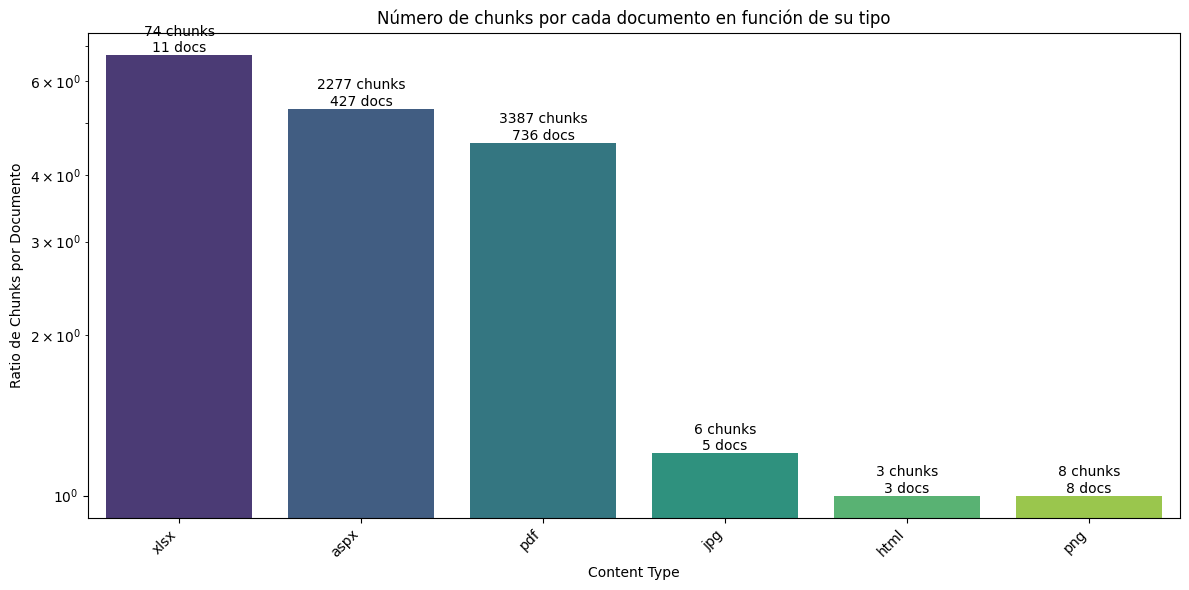

In [76]:
warnings.filterwarnings("ignore")
fig=chunk_doc_relation()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [84]:
def umap_3d_projection():
    # Step 1: Reduce dimensions using UMAP to 3D
    content_vectors = np.array(embeddings_df['content_vector_norm'].tolist())
    umap_model = umap.UMAP(n_components=3, random_state=42)
    umap_result = umap_model.fit_transform(content_vectors)

    # Step 2: Create a DataFrame with the UMAP results
    umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])
    umap_df['Content_Type'] = embeddings_df['content_type']  # Add content type from embeddings_df

    # Step 3: Create a 3D scatter plot with matplotlib
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Add scatter points for each content type
    for content_type in umap_df['Content_Type'].unique():
        subset = umap_df[umap_df['Content_Type'] == content_type]
        ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'], s=50, label=content_type, cmap='viridis')

    # Update layout for the 3D plot
    ax.set_title('3D UMAP Projection of Content Vectors')
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')

    # Add legend
    ax.legend()

    # Show the figure (non-interactive)
    plt.show()

    return fig


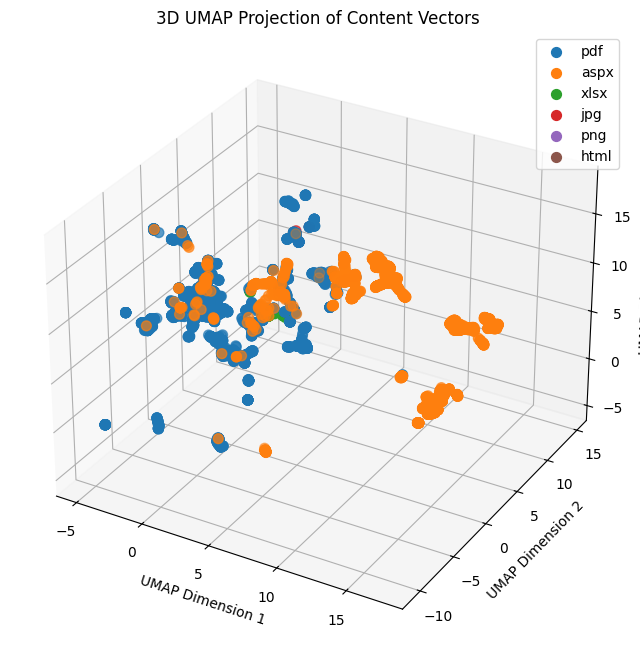

El gráfico muestra una proyección 3D de vectores de contenido utilizando UMAP (Uniform Manifold Approximation and Projection). Los puntos en el gráfico están coloreados según el tipo de archivo: pdf, aspx, xlsx, jpg, png y html.

Principales observaciones:

1. **Agrupación por Tipo de Archivo**: 
   - Los puntos correspondientes a archivos `pdf` (azul) y `aspx` (naranja) parecen estar distribuidos en diferentes regiones del espacio 3D, aunque hay cierta superposición.
   - Los puntos de otros tipos de archivos (`xlsx`, `jpg`, `png`, `html`) son menos frecuentes y están dispersos en el gráfico.

2. **Distribución de los Datos**:
   - Los archivos `pdf` y `aspx` muestran una mayor densidad de puntos, lo que sugiere que hay más ejemplos de estos tipos de archivos en el conjunto de datos.
   - Los puntos de `xlsx`, `jpg`, `png` y `html` están más dispersos y son menos numerosos, lo que podría indicar una menor representación de estos tipos de archivos.

3. **Separación de Clusters**:
   - 

In [85]:
warnings.filterwarnings("ignore")
fig=umap_3d_projection()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

# II) Análisis en función de category

Asignar color a cada tipo de chunk

In [86]:
color_mapping = {
    'site': '#FFB347',
    'calendar': '#84b6f4',  
    'table': '#77dd77',    
    'document': '#ff6961',      
}
embeddings_df['color'] = embeddings_df['category'].map(color_mapping)

In [87]:
embeddings_df.category.value_counts()

category
document    3404
calendar    1601
site         676
table         74
Name: count, dtype: int64

In [91]:
def chunks_per_category():
    # Contar la cantidad de 'chunk_id' por 'category'
    chunk_count_per_type = embeddings_df.groupby('category')['chunk_id'].count().reset_index()

    # Renombrar las columnas para mayor claridad
    chunk_count_per_type.columns = ['category', 'chunk_count']

    # Ordenar por 'chunk_count' de manera descendente
    chunk_count_per_type = chunk_count_per_type.sort_values(by='chunk_count', ascending=False)

    # Crear el gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    ax = sns.barplot(x='category', y='chunk_count', data=chunk_count_per_type, palette='viridis')

    # Establecer el eje Y en escala logarítmica
    ax.set(yscale='log')

    # Agregar los valores sobre cada barra
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',  # El valor sobre la barra
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Coordenadas (posición)
                    ha='center', va='center',  # Alineación
                    fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    # Agregar título y etiquetas
    ax.set_title('Count of Chunk IDs per Content Type')
    ax.set_xlabel('Category')
    ax.set_ylabel('Count of Chunk IDs (log scale)')

    # Rotar las etiquetas del eje X si es necesario
    plt.xticks(rotation=45, ha='right')

    # Ajustar el diseño para evitar el solapamiento de etiquetas
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    # Si deseas devolver la figura para guardarla o modificarla más tarde:
    return ax.figure


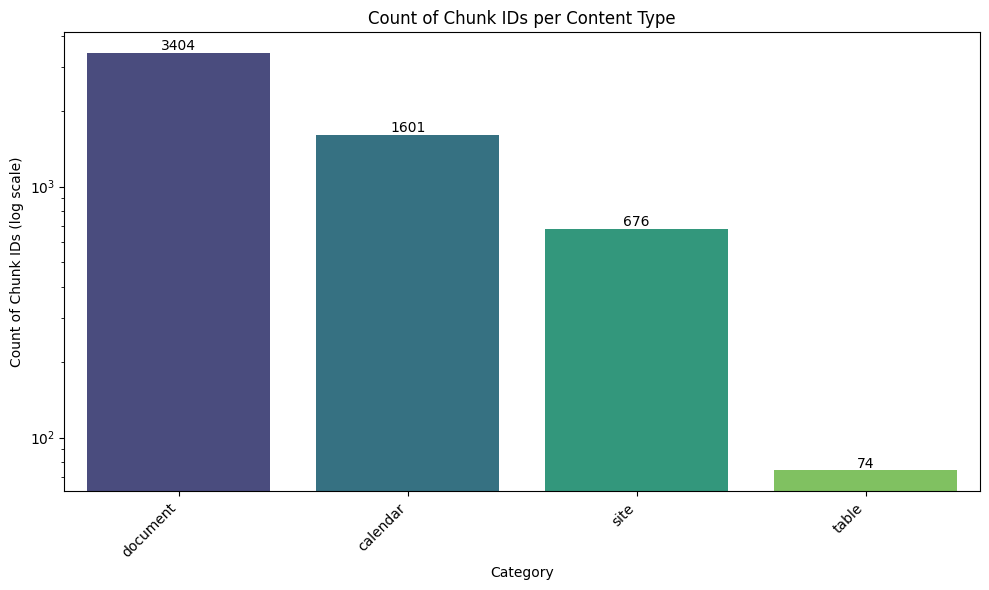

El gráfico muestra la cantidad de IDs de fragmentos por tipo de contenido, utilizando una escala logarítmica para el eje y. Las categorías de contenido incluidas son "document", "calendar", "site" y "table".

Principales tendencias y conclusiones:
1. **Documentos**: Esta categoría tiene la mayor cantidad de IDs de fragmentos, con un total de 3404. Esto sugiere que los documentos son el tipo de contenido más común.
2. **Calendarios**: La segunda categoría más común, con 1601 IDs de fragmentos. Aunque significativamente menor que los documentos, sigue siendo una cantidad considerable.
3. **Sitios**: Con 676 IDs de fragmentos, los sitios ocupan el tercer lugar en términos de cantidad.
4. **Tablas**: Esta es la categoría menos común, con solo 74 IDs de fragmentos, lo que indica que las tablas son el tipo de contenido menos frecuente.

En resumen, los documentos son el tipo de contenido más prevalente, seguidos por los calendarios y los sitios, mientras que las tablas son las menos comunes.

In [92]:
warnings.filterwarnings("ignore")
fig=chunks_per_category()
fig_array = fig_to_image(fig)
interpretation = openai_client.prompt_image(model_name, fig_array, system_prompt)
print(interpretation)

In [18]:
# Count the quantity of chunk_id per content_type
chunk_count_per_type = embeddings_df.groupby('category')['chunk_id'].count().reset_index()
chunk_count_per_type.columns = ['category', 'chunk_count']

# Count the quantity of unique document_id per content_type
doc_count_per_type = embeddings_df.groupby('category')['document_id'].nunique().reset_index()
doc_count_per_type.columns = ['category', 'doc_count']

# Merge the two DataFrames on content_type
merged_counts = pd.merge(chunk_count_per_type, doc_count_per_type, on='category')

# Calculate the ratio of chunk_count to doc_count
merged_counts['ratio'] = merged_counts['chunk_count'] / merged_counts['doc_count']

# Sort by ratio in descending order
merged_counts = merged_counts.sort_values(by='ratio', ascending=False)

# Create a bar plot with a logarithmic y-axis
fig = px.bar(merged_counts,
             x='category',
             y='ratio',
             title='Número de chunks por cada documento en función de su tipo',
             labels={'category': 'category Type',
                     'ratio': 'Ratio of Chunk Count to Document Count'},
             color='ratio',  # Color by ratio
             color_continuous_scale=px.colors.sequential.Viridis)  # Optional color scale

# Add text annotations for the number of document_ids and chunk_ids
fig.update_traces(text=merged_counts['chunk_count'].astype(str) + ' chunks<br>' + 
                  merged_counts['doc_count'].astype(str) + ' docs', 
                  textposition='auto')

# Update layout for logarithmic scale
fig.update_layout(
    yaxis_title='Ratio chunks per document',
    yaxis_type= 'log',
    xaxis_title='category Type',
    height=600,
    width=1200
)

# Show the figure
fig.show()


In [19]:
import pandas as pd
import numpy as np
import umap
import plotly.graph_objects as go

# Assuming 'embeddings_df' contains the 'content_vector_norm' column as a list of lists
# Convert content_vector_norm to a NumPy array
content_vectors = np.array(embeddings_df['content_vector_norm'].tolist())

# Step 1: Reduce dimensions using UMAP to 3D
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_result = umap_model.fit_transform(content_vectors)

# Step 2: Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['category'] = embeddings_df['category']  # Add content type from embeddings_df
umap_df['Color_Variable'] = embeddings_df['color']  # Add the color variable from embeddings_df

# Step 3: Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each content type
for content_type in umap_df['category'].unique():
    subset = umap_df[umap_df['category'] == content_type]
    fig.add_trace(go.Scatter3d(
        x=subset['UMAP1'],
        y=subset['UMAP2'],
        z=subset['UMAP3'],
        mode='markers',
        marker=dict(size=5, color=subset['Color_Variable']),
        name=content_type
    ))

# Update layout for the 3D plot
fig.update_layout(
    title='3D UMAP Projection of Content Vectors',
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3'
    ),
    height=600,
    width=800,
)

# Show the figure (non-interactive)
fig.show()  # Use 'png' or 'jpeg' for a static image


c:\Users\55641856\Desktop\ai search codigo\dch_asistente_etl\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [20]:
content_vectors = np.array(embeddings_df['content_vector_norm'].tolist())

# Step 1: Add content_vector_norm to embeddings_df for easier access
embeddings_df['content_vector_norm'] = content_vectors.tolist()

# Step 2: Calculate the centroid for each category
centroids = embeddings_df.groupby('category')['content_vector_norm'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['category', 'center_category']

# Step 3: Merge the centroids back into the original embeddings_df
embeddings_df = embeddings_df.merge(centroids, on='category', how='left')

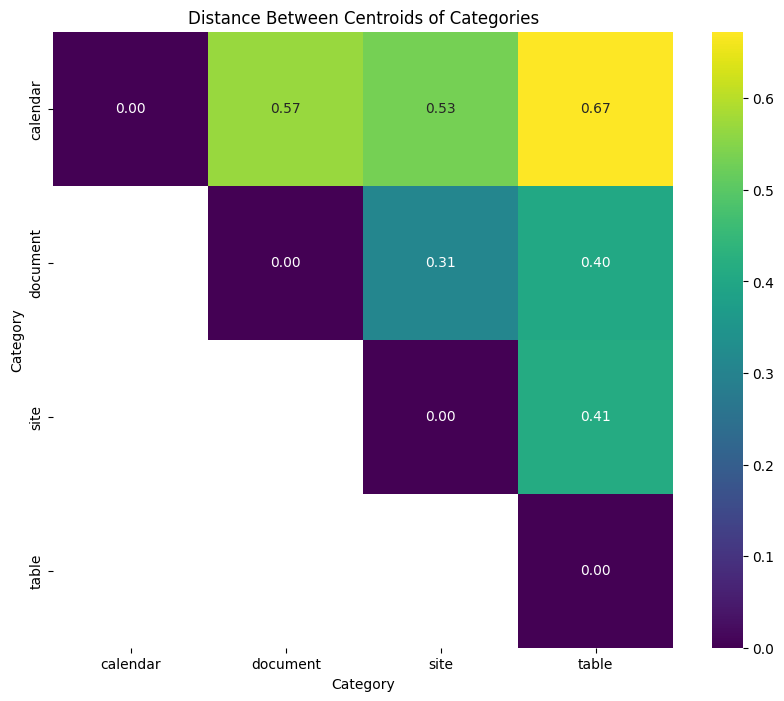

In [21]:
centroids = embeddings_df.groupby('category')['content_vector_norm'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['category', 'center_category']

# Convert center_category to a NumPy array for distance calculations
centroid_vectors = np.array(centroids['center_category'].tolist())

# Step 2: Compute the distance matrix
distance_matrix = squareform(pdist(centroid_vectors))

# Step 3: Create a DataFrame for distances
distance_df = pd.DataFrame(distance_matrix, columns=centroids['category'], index=centroids['category'])

# Step 4: Create a mask for the lower triangle
mask = np.tril(np.ones_like(distance_df, dtype=bool), k=-1)

# Step 5: Create a heatmap of the lower triangle distances
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, mask=mask, annot=True, fmt=".2f", cmap='viridis')
plt.title('Distance Between Centroids of Categories')
plt.xlabel('Category')
plt.ylabel('Category')
plt.show()


c:\Users\55641856\Desktop\ai search codigo\dch_asistente_etl\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



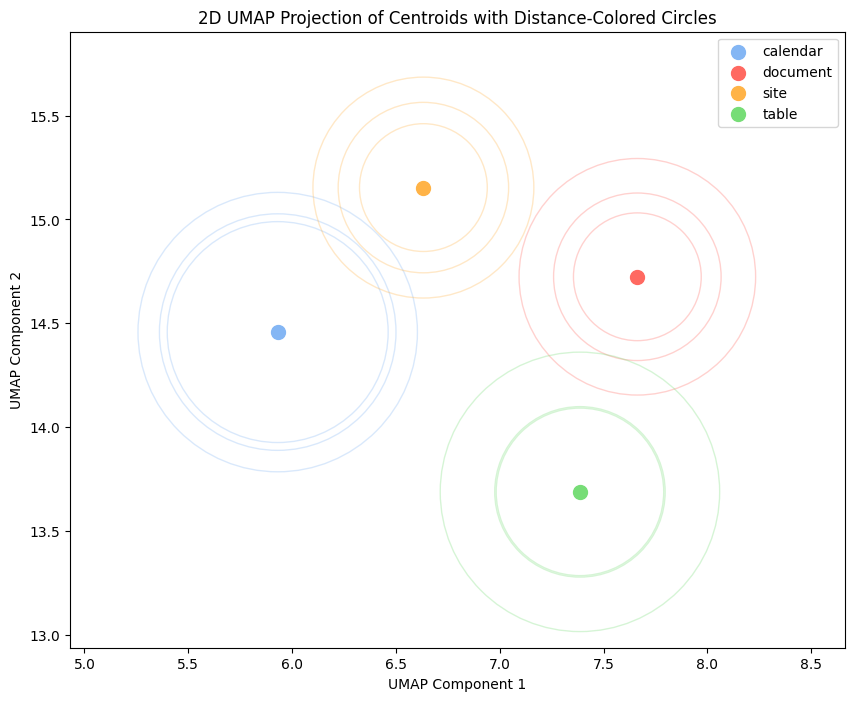

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from scipy.spatial.distance import pdist, squareform

# Assuming `embeddings_df` is already defined and contains your data

# Step 1: Calculate centroids
centroids = embeddings_df.groupby('category')['center_category'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['category', 'center_category']

# Convert center_category to a NumPy array for distance calculations
centroid_vectors = np.array(centroids['center_category'].tolist())

# Step 2: Compute the distance matrix
# compute the pairwise distances between all pairs of your 3000-dimensional centroid vectors

# squareform(...): This will then take the condensed output from pdist and transform it into a 2D 
# square matrix. The resulting matrix will be of size n×n, where 𝑛 is the number of centroid vectors. Each entry (i,j) in this matrix contains the distance 
# between the i-th and j-th vectors.
distance_matrix = squareform(pdist(centroid_vectors)) 

# Step 3: Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
centroid_2d = umap_model.fit_transform(centroid_vectors)

# Step 4: Get color mapping from embeddings_df
color_mapping = embeddings_df.set_index('category')['color'].to_dict()  # Replace 'color' with your actual column name

# Step 5: Plotting
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(centroid_2d):
    category = centroids['category'].iloc[i]
    color = color_mapping.get(category, 'b')  # Default to blue if not found
    plt.scatter(x, y, label=category, color=color, s=100)
    
    # Step 6: Add circles around centroids
    distances = distance_matrix[i]  # Distances from the current centroid to others
    for j, d in enumerate(distances):
        if j != i:  # Ensure we only plot circles for other centroids
            # Radius should be half the distance to the other centroid
            radius = d 
            circle = plt.Circle((x, y), radius, color=color, fill=False, alpha=0.3)
            plt.gca().add_artist(circle)

plt.title('2D UMAP Projection of Centroids with Distance-Colored Circles')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.axis('equal')
plt.xlim(np.min(centroid_2d[:, 0]) - 1, np.max(centroid_2d[:, 0]) + 1)
plt.ylim(np.min(centroid_2d[:, 1]) - 1, np.max(centroid_2d[:, 1]) + 1)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from scipy.spatial.distance import pdist, squareform

# Assuming `embeddings_df` is already defined and contains your data

# Step 1: Calculate centroids
centroids = embeddings_df.groupby('category')['center_category'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['category', 'center_category']

# Convert center_category to a NumPy array for distance calculations
centroid_vectors = np.array(centroids['center_category'].tolist())

# Step 2: Compute the distance matrix
distance_matrix = squareform(pdist(centroid_vectors))

# Step 3: Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
centroid_2d = umap_model.fit_transform(centroid_vectors)

# Step 4: Get color mapping from embeddings_df
color_mapping = embeddings_df.set_index('category')['color'].to_dict()  # Replace 'color' with your actual column name

# Step 5: Plotting
plt.figure(figsize=(10, 8))

# Step 6: Add points for centroids
for i, (x, y) in enumerate(centroid_2d):
    category = centroids['category'].iloc[i]
    color = color_mapping.get(category, 'b')  # Default to blue if not found
    plt.scatter(x, y, label=category, color=color, s=100)
    
    # Step 7: Add circles around centroids
    radius = np.max(distance_matrix[i])  # Use max distance to define circle radius
    circle = plt.Circle((x, y), radius, color=color, fill=False, alpha=0.5)
    plt.gca().add_artist(circle)

# Highlighting the centroids
plt.scatter(centroid_2d[:, 0], centroid_2d[:, 1], edgecolor='black', s=200, linewidth=1.5, alpha=0.7)

plt.title('2D UMAP Projection of Centroids with Distance-Colored Circles')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.axis('equal')
plt.xlim(np.min(centroid_2d[:, 0]) - 1, np.max(centroid_2d[:, 0]) + 1)
plt.ylim(np.min(centroid_2d[:, 1]) - 1, np.max(centroid_2d[:, 1]) + 1)
plt.show()


## III) Análisis en función de cluster

Asignamos un número a cada etiqueta

In [143]:
# Paso 1: Crear un diccionario para asignar números a cada etiqueta
etiquetas_unicas = embeddings_df['etiqueta_asignada'].unique()
etiqueta_dict = {etiqueta: i for i, etiqueta in enumerate(etiquetas_unicas)}

# Paso 2: Crear una nueva columna en el DataFrame
embeddings_df['etiqueta_numero'] = embeddings_df['etiqueta_asignada'].map(etiqueta_dict)

Visualización por tipo de documento y cluster

In [ ]:
import pandas as pd
import plotly.express as px

# Paso 3: Agrupar por 'etiqueta_asignada' y 'category'
grouped = embeddings_df.groupby(['etiqueta_asignada', 'category']).size().reset_index(name='count')

# Paso 4: Calcular totales para cada 'etiqueta_asignada'
grouped['total'] = grouped.groupby('etiqueta_asignada')['count'].transform('sum')

# Paso 5: Calcular proporciones
grouped['proportion'] = (grouped['count'] / grouped['total']) * 100
grouped['proportion'] = grouped['proportion'].round(1)

# Paso 6: Sort values by 'etiqueta_numero' for the x-axis
grouped['etiqueta_numero'] = grouped['etiqueta_asignada'].map(etiqueta_dict)
grouped = grouped.sort_values(by='etiqueta_numero')

# Paso 7: Define color mapping
color_mapping = {
    'document': '#ff6961',
    'site': '#FFB347',
    'calendar': '#84b6f4',
    'table': '#77dd77'
}

# Paso 8: Crear el gráfico de barras de Plotly para las proporciones
fig = px.bar(
    grouped,
    x='etiqueta_numero',  # Usar el número de etiqueta en el eje x
    y='proportion',
    color='category',
    labels={'etiqueta_numero': 'Cluster (Etiqueta Asignada)', 'proportion': 'Proportion'},
    text='proportion',  # Mostrar proporciones en las barras
    color_discrete_map=color_mapping  # Usar mapeo de colores aquí
)

# Paso 9: Actualizar el diseño
fig.update_layout(
    xaxis_title='Proporciones de Categorías dentro de Cada Cluster (Etiqueta Asignada)',
    yaxis_title='Proporción',
    barmode='stack',
    xaxis=dict(tickvals=list(etiqueta_dict.values())),  # Mostrar etiquetas
    width=1200,  # Ajustar el ancho del gráfico
    height=600,
    bargap=0.1
)

# Paso 10: Mostrar el gráfico
fig.show()


Distribución de etiquetas

In [ ]:
plt.figure(figsize=(16, 8))  # Aumentar el tamaño de la figura

# Contar los chunks por etiqueta_numero
chunks = embeddings_df['etiqueta_numero'].value_counts()
count_documents = embeddings_df.groupby('etiqueta_numero')['document_id'].nunique()

# Contar el total de chunks y documentos
total_chunks = chunks.sum()
total_documents = count_documents.sum()

# Imprimir los resultados
print("Total de Chunks:", total_chunks)
print("Total de Documentos:", total_documents)

# Calcular el ratio y ordenar por etiqueta_numero
ratio = (chunks / count_documents).sort_index()  # Usar sort_index() para mantener el orden

# Crear el gráfico de barras vertical
ax = ratio.plot(kind='bar', color='skyblue')

# Agregar los valores en las barras
for index, value in enumerate(ratio):
    ax.text(index, value, f'{value:.2f}', ha='center', va='bottom')  # Cambiar la posición del texto

# Configurar título y etiquetas
plt.title('Relación entre el número chunks y cantidad de documentos por cluster', fontsize=16)
plt.xlabel('Etiqueta de Cluster (Número Asignado)', fontsize=14)
plt.ylabel('Conteo de chunks ajustado al número de documentos', fontsize=14)

# Ajustar el diseño
plt.xticks(rotation=0)  # Asegúrate de que las etiquetas del eje x sean legibles
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Para cada cluster, cuantos chunks pertenecen al mismo documento?

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming embeddings_df is already defined and contains the necessary columns

# Drop unnecessary columns
columns_to_remove = [
    'center_category_x', 'is_outlier',
    'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
    'center_category_y', 'All_Same_Cluster_Grouped_x', 
    'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
]
embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Step 1: Group by 'document_id' and count unique clusters
grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()

# Step 2: Identify if all chunks of a document are in the same cluster
grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1  # True if only one unique cluster

# Merge the All_Same_Cluster flag back to the original DataFrame
embeddings_df = embeddings_df.merge(
    grouped[['document_id', 'All_Same_Cluster']], 
    on='document_id', 
    how='left'
)

# Step 3: Create a DataFrame for counting based on 'All_Same_Cluster'
count_status = (
    embeddings_df.groupby(['etiqueta_numero', 'All_Same_Cluster', 'category'])
    .size()
    .reset_index(name='Document_Count')
)

# Step 4: Create the plots for each cluster
fig = px.bar(
    count_status,
    x='etiqueta_numero',
    y='Document_Count',
    color='category',
    barmode='group',
    labels={
        'etiqueta_numero': 'Cluster',
        'Document_Count': 'Count of Documents',
        'All_Same_Cluster': 'All Chunks in Same Cluster?'
    },
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Update layout for the main figure
fig.update_layout(
    title_text='Document Count by Cluster',
    height=600,
    width=1800,
    barmode='group',
    legend_title_text='Category'
)

fig.show()


In [ ]:
import pandas as pd
import plotly.subplots as sp
import plotly.express as px

# Drop unnecessary columns
columns_to_remove = [
    'center_category_x', 'is_outlier',
    'All_Same_Cluster_x', 'All_Same_Cluster_y', 'All_Same_Cluster',
    'center_category_y', 'All_Same_Cluster_Grouped_x', 
    'All_Same_Cluster_Grouped_y', 'All_Same_Cluster_Grouped'
]
embeddings_df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Step 1: Group by 'document_id' and count unique clusters
grouped = embeddings_df.groupby('document_id')['etiqueta_numero'].nunique().reset_index()
grouped['All_Same_Cluster'] = grouped['etiqueta_numero'] == 1

# Merge the All_Same_Cluster flag back to the original DataFrame
embeddings_df = embeddings_df.merge(
    grouped[['document_id', 'All_Same_Cluster']], 
    on='document_id', 
    how='left'
)

# Step 2: Create a DataFrame for counting based on 'All_Same_Cluster'
count_status = (
    embeddings_df.groupby(['etiqueta_numero', 'All_Same_Cluster', 'category'])
    .size()
    .reset_index(name='Document_Count')
)

# Step 3: Create subplots
unique_clusters = embeddings_df['etiqueta_numero'].unique()
n_clusters = len(unique_clusters)

# Define the number of columns for the grid layout
n_cols = 6  # Adjust as needed
n_rows = (n_clusters + n_cols - 1) // n_cols  # Calculate required rows

# Create a subplot grid with adjusted vertical spacing
fig = sp.make_subplots(
    rows=n_rows, 
    cols=n_cols, 
    shared_xaxes=True,
    vertical_spacing=0.02,  # Set a smaller value for vertical spacing
    subplot_titles=[f'Cluster {cluster}' for cluster in unique_clusters]
)

# Step 4: Add bar plots for each cluster
for i, cluster in enumerate(unique_clusters):
    cluster_data = count_status[count_status['etiqueta_numero'] == cluster]
    bar_fig = px.bar(
        cluster_data,
        x='All_Same_Cluster',
        y='Document_Count',
        color='category',
        labels={
            'All_Same_Cluster': 'All Chunks in Same Cluster?',
            'Document_Count': 'Count of Documents'
        },
        barmode='stack'  # Stack the bars
    )
    
    # Add each bar plot to the corresponding subplot
    for trace in bar_fig.data:
        fig.add_trace(trace, row=i // n_cols + 1, col=i % n_cols + 1)

# Update layout for the main figure
fig.update_layout(
    title_text='Document Count by Cluster',
    height=600 + (n_rows - 1) * 200,  # Adjust height based on number of rows
    showlegend=False  # Remove legend
)

# Show the combined figure with subplots
fig.show()anali

In [ ]:
centroids = embeddings_df.groupby('etiqueta_numero')['centroide'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['etiqueta_numero', 'centroide']

# Convert centroide to a NumPy array for distance calculations
centroid_vectors = np.array(centroids['centroide'].tolist())

# Step 3: Compute the distance matrix (optional if not used)
distance_matrix = squareform(pdist(centroid_vectors))

# Step 4: Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
centroid_2d = umap_model.fit_transform(centroid_vectors)

# Step 5: Plotting with increased size
plt.figure(figsize=(12, 10))

# Step 6: Add points for centroids with assigned colors
for i, (x, y) in enumerate(centroid_2d):
    etiqueta = centroids['etiqueta_numero'].iloc[i]
    plt.scatter(x, y, label=etiqueta, s=100)
    # Add the etiqueta_numero as text next to the data points
    plt.text(x, y, str(centroids['etiqueta_numero'].iloc[i]), fontsize=10, ha='center', va='center', color='black')

# Highlighting the centroids
plt.scatter(centroid_2d[:, 0], centroid_2d[:, 1], edgecolor='black', s=200, linewidth=1.5, alpha=0.7)

plt.title('2D UMAP Projection of Centroids', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)
plt.axis('equal')
plt.xlim(np.min(centroid_2d[:, 0]) - 1, np.max(centroid_2d[:, 0]) + 1)
plt.ylim(np.min(centroid_2d[:, 1]) - 1, np.max(centroid_2d[:, 1]) + 1)
plt.show()


In [ ]:
centroids = embeddings_df.groupby('etiqueta_numero')['centroide'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['etiqueta_numero', 'centroide']

# Convert centroide to a NumPy array for distance calculations
centroid_vectors = np.array(centroids['centroide'].tolist())

# Step 3: Compute the distance matrix
distance_matrix = squareform(pdist(centroid_vectors))

# Step 4: Calculate the maximum distance for each centroid and compute the circumference
circumferences = []
for i in range(distance_matrix.shape[0]):
    radius = np.max(distance_matrix[i])  # You can use np.mean(distance_matrix[i]) if preferred
    circumference = 2 * np.pi * radius
    circumferences.append(circumference)

# Step 5: Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
centroid_2d = umap_model.fit_transform(centroid_vectors)

# Step 6: Plotting with increased size
plt.figure(figsize=(12, 10))

# Step 7: Add points for centroids with assigned colors
for i, (x, y) in enumerate(centroid_2d):
    etiqueta = centroids['etiqueta_numero'].iloc[i]
    plt.scatter(x, y, label=etiqueta,  s=100)
    
    # Step 8: Add circles around centroids
    radius = np.max(distance_matrix[i])  # Use max distance to define circle radius
    circle = plt.Circle((x, y), radius,  fill=False, alpha=0.3)  # Color circles based on cluster
    plt.gca().add_artist(circle)
    plt.text(x, y, str(centroids['etiqueta_numero'].iloc[i]), fontsize=10, ha='center', va='center', color='black')

    #print(f'Circumference of centroid for etiqueta {etiqueta}: {circumferences[i]:.2f}')

# Highlighting the centroids
plt.scatter(centroid_2d[:, 0], centroid_2d[:, 1], edgecolor='black', s=200, linewidth=1.5, alpha=0.7)

plt.title('2D UMAP Projection of Centroids with Circumference Circles', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)
plt.axis('equal')
plt.xlim(np.min(centroid_2d[:, 0]) - 1, np.max(centroid_2d[:, 0]) + 1)
plt.ylim(np.min(centroid_2d[:, 1]) - 1, np.max(centroid_2d[:, 1]) + 1)
plt.show()


In [ ]:
# Step 2: Calculate centroids using 'centroide'
centroids = embeddings_df.groupby('etiqueta_numero')['centroide'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
centroids.columns = ['etiqueta_numero', 'centroide']

# Convert centroide to a NumPy array for distance calculations
centroid_vectors = np.array(centroids['centroide'].tolist())

# Step 3: Compute the distance matrix
distance_matrix = squareform(pdist(centroid_vectors))

# Step 4: Create a mask for the lower triangle
mask = np.triu(np.ones_like(distance_matrix, dtype=bool))

# Step 5: Set up the plot
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, mask=mask, cmap='viridis', annot=False, square=True, cbar_kws={"shrink": .8}, xticklabels=centroids['etiqueta_numero'], yticklabels=centroids['etiqueta_numero'])

# Step 6: Show the plot
plt.title('Lower Triangle of Distance Matrix')
plt.xlabel('Cluster Labels')
plt.ylabel('Cluster Labels')
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(distance_matrix.shape[0])
y = np.arange(distance_matrix.shape[1])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, distance_matrix, cmap='viridis')
ax.set_title('3D Surface Plot of Distance Matrix')
ax.set_xlabel('Centroids')
ax.set_ylabel('Centroids')
ax.set_zlabel('Distance')
plt.show()


### Cálculo de valores atípicos

1) z-score

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import pairwise
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_asignada):
    # Calculate the centroid
    centroid = np.mean(cluster_data, axis=0)
    distances = pairwise.euclidean_distances(cluster_data, [centroid]).flatten()
    
    # Calculate mean and standard deviation
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)

    # Z-score calculation
    z_scores = (distances - mean_distance) / std_distance
    
    # Define threshold for outliers
    threshold = 3  # You can adjust this threshold
    outliers = distances[z_scores > threshold]

    # Create a DataFrame for Plotly
    data_to_plot = pd.DataFrame({'Distancia': distances, 'Cluster': etiqueta_asignada})
    
    return data_to_plot, mean_distance, threshold, len(outliers), len(cluster_data)

# Assume embeddings_df is your DataFrame with cluster labels
combined_data = pd.DataFrame()  # Initialize an empty DataFrame to collect all data

# Generate boxplots and count outliers for each cluster
for label in embeddings_df['etiqueta_numero'].unique():
    cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
    data_to_plot, mean_distance, threshold, num_outliers, total_embeddings = plot_boxplots_and_identify_outliers(cluster_data, label)

    combined_data = pd.concat([combined_data, data_to_plot], ignore_index=True)  # Combine results

    # Print the number of outliers and total embeddings
    if num_outliers > 0:
        per_outliers = (num_outliers * 100 / total_embeddings) if total_embeddings > 0 else 0
        per_outliers = round(per_outliers, 3)
        print(f'Cluster: {label}')
        print(f'{num_outliers} outliers identified from {total_embeddings} total embeddings.')
        print(f'Percentage of total outliers is {per_outliers}%.')
        print()

# Create a vertical plot with horizontal boxplots (clusters on x-axis)
fig = px.box(combined_data, x='Cluster', y='Distancia', 
              title='Boxplots with Outliers Identified Based on Distances to Centroid',
              color='Cluster',  # Add color based on cluster
              color_discrete_sequence=px.colors.qualitative.Pastel  # Use lighter pastel colors
             )

# Update layout to show mean and standard deviation
fig.update_traces(boxmean='sd')  # Show mean and standard deviation

# Remove the legend
fig.update_layout(showlegend=False)

# Update figure size
fig.update_layout(width=1500, height=900)  # Set the width and height

# Show the figure
fig.show()

print("Boxplots of distances to the centroid generated and outliers identified.")


3) Local Outlier Factor

It produces an anomaly score that represents data points which are outliers in the data set. It does this by measuring the local density deviation of a given data point with respect to the data points near it. Working of LOF: Local density is determined by estimating distances between data points that are neighbors (k-nearest neighbors). So for each data point, local density can be calculated. By comparing these we can check which data points have similar densities and which have a lesser density than its neighbors. The ones with the lesser densities are considered as the outliers. 
https://www.geeksforgeeks.org/local-outlier-factor/

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor

# Function to identify outliers and prepare data for plotting
def plot_boxplots_and_identify_outliers(cluster_data, etiqueta_numero, contamination):
    # Fit Local Outlier Factor
    tam=(len(cluster_data))
    neig= abs(tam*0.25)
    neig= int(neig)
    lof = LocalOutlierFactor(n_neighbors=neig, contamination=contamination)
    outlier_labels = lof.fit_predict(cluster_data)
    
    # Identify inliers and outliers
    is_outlier = outlier_labels == -1
    num_outliers = np.sum(is_outlier)
    
    # Create a DataFrame for plotting
    distances = lof.negative_outlier_factor_  # Get the negative outlier factor for distances
    data_to_plot = pd.DataFrame({'Distancia': -distances, 'Cluster': etiqueta_numero})
    
    return data_to_plot, num_outliers, is_outlier

contamination = 'auto'  # Adjust contamination as needed

# Prepare a list to gather all data and a dictionary to count outliers
all_data = []
outlier_counts = {}

# Create an array to store outlier information
all_outlier_labels = []

# Generate boxplots and count outliers for each cluster
for idx, label in enumerate(embeddings_df['etiqueta_numero'].unique()):
    cluster_data = np.array(embeddings_df[embeddings_df['etiqueta_numero'] == label]['content_vector_norm'].tolist())
    data_to_plot, num_outliers, is_outlier = plot_boxplots_and_identify_outliers(cluster_data, label, contamination)

    # Append data for the current cluster to the list
    all_data.append(data_to_plot)

    # Store outlier labels for the current cluster
    all_outlier_labels.append(pd.Series(is_outlier, index=embeddings_df[embeddings_df['etiqueta_numero'] == label].index))

    # Store the number of outliers
    outlier_counts[label] = num_outliers
    
    # Print the cluster index (number) and name (label)
    if num_outliers>0:
        print(f"Cluster Number: {idx}, Cluster Name: {label}, Number of Outliers: {num_outliers}")

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Create a DataFrame for outlier counts and sort it
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Cluster', 'Num_Outliers'])
outlier_counts_df['Cluster'] = outlier_counts_df['Cluster'].astype('category')
outlier_counts_df = outlier_counts_df.sort_values(by='Num_Outliers', ascending=False)

# Ensure the cluster labels are preserved
combined_data['Cluster'] = combined_data['Cluster'].astype('category')

# Concatenate the outlier labels into a single Series
embeddings_df['is_outlier'] = pd.concat(all_outlier_labels)

# Optionally convert is_outlier to categorical
embeddings_df['is_outlier'] = embeddings_df['is_outlier'].map({True: '1', False: '0'}).astype('category')

# Create a vertical plot with horizontal boxplots (clusters on x-axis)
fig = px.box(combined_data, x='Cluster', y='Distancia', 
              title='Boxplots con valores atípicos en función del método Local Outlier Factor',
              labels={'Distancia': 'Distancia en función de la densidad local del cluster'},
              color='Cluster',  # Add color based on cluster
              color_discrete_sequence=px.colors.qualitative.Pastel)

# Update layout to show mean and standard deviation
fig.update_traces(boxmean='sd')  # Show mean and standard deviation

# Remove the legend
fig.update_layout(showlegend=False)

# Update figure size
fig.update_layout(width=1500, height=900)  # Set the width and height

# Show the figure
fig.show()


3) Robust covariance

https://scikit-learn.org/1.5/auto_examples/covariance/plot_robust_vs_empirical_covariance.html

https://scikit-learn.org/1.5/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py

https://scikit-learn.org/1.5/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope

In [ ]:
from sklearn.covariance import MinCovDet

warnings.filterwarnings("ignore")

# Assuming embeddings_df is already defined and contains the relevant data
umap_model = umap.UMAP(n_components=3)
umap_result = umap_model.fit_transform(np.array(embeddings_df['content_vector_norm'].tolist()))

# Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['Cluster'] = embeddings_df['etiqueta_numero']  # Add cluster labels
umap_df['Chunk_ID'] = embeddings_df['chunk_id']  # Add chunk IDs
umap_df['Document_ID'] = embeddings_df['document_id']  # Add document IDs

# Initialize a DataFrame to collect outlier results
outlier_results = []

# Perform outlier detection for each cluster
for cluster in umap_df['Cluster'].unique():
    cluster_data = umap_df[umap_df['Cluster'] == cluster][['UMAP1', 'UMAP2', 'UMAP3']]
    
    # Fit Minimum Covariance Determinant model for outlier detection
    mcd = MinCovDet()
    mcd.fit(cluster_data)

    # Calculate Mahalanobis distances
    mahal_distances = mcd.mahalanobis(cluster_data)

    # Set a threshold to classify outliers
    threshold = np.percentile(mahal_distances, 95)  # 95th percentile as threshold for outliers
    
    # Mark outliers in the original DataFrame
    umap_df.loc[umap_df['Cluster'] == cluster, 'Outlier'] = mahal_distances > threshold

    # Collect outlier data for each cluster
    outlier_data = cluster_data[mahal_distances > threshold]
    outlier_data['Cluster'] = cluster
    outlier_data['Outlier'] = True
    outlier_results.append(outlier_data)

# Combine all outlier results into a single DataFrame
outlier_df = pd.concat(outlier_results)

# Create a grid of scatter plots
num_clusters = len(umap_df['Cluster'].unique())
cols = 5
rows = (num_clusters + cols - 1) // cols  # Calculate the number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(20, 25))
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for idx, cluster in enumerate(umap_df['Cluster'].unique()):
    cluster_data = umap_df[umap_df['Cluster'] == cluster]
    
    axs[idx].scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], label='Data Points', alpha=0.6)
    
    # Highlight outliers if any
    if 'Outlier' in cluster_data.columns and cluster_data['Outlier'].any():
        outliers = cluster_data[cluster_data['Outlier'] == True]
        axs[idx].scatter(outliers['UMAP1'], outliers['UMAP2'], color='red', label='Outliers', marker='x')

    axs[idx].set_title(f'Cluster: {cluster}', fontsize=12)
    axs[idx].set_xlabel('UMAP Dimension 1', fontsize=10)
    axs[idx].set_ylabel('UMAP Dimension 2', fontsize=10)
    axs[idx].legend()
    axs[idx].grid(True)

# Hide any unused subplots
for j in range(num_clusters, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
